In [567]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pickle
import h5py
import scipy.stats
from tqdm import tqdm
import pdb
import os
from matplotlib.backends.backend_pdf import PdfPages
import sklearn.preprocessing
###Import functions for binning data for preprocessing###
from Neural_Decoding.preprocessing_funcs import bin_spikes
from Neural_Decoding.preprocessing_funcs import bin_output
#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho
#Import decoder functions
from Neural_Decoding.decoders import NaiveBayesDecoder
import statsmodels.api as sm


behav_mat = loadmat('behav_new.mat');
behav_pos = behav_mat['behav']["position_original"][0][0]
behav_pos_smooth = behav_mat['behav']["position"][0][0]
behav_time = behav_mat['behav']['time'][0][0]

# delete first 50 frames (~1.7s), when the mouse is not in the maze
delete_start = 50
behav_pos = np.delete(behav_pos, range(0,delete_start),0)
behav_time = np.delete(behav_time, range(0,delete_start))
behav_pos_smooth = np.delete(behav_pos_smooth, range(0,delete_start),0)


# behav_mat = loadmat('ms.mat');
# read calcium data
with h5py.File('ms.mat', 'r') as f:
    ms_mat = f['ms']
    FiltTraces = np.array(ms_mat['FiltTraces'])
    RawTraces = np.array(ms_mat['RawTraces'])
    DeconvSignal = np.array(ms_mat['DeconvSignals'])
    ms_time = np.array(ms_mat['time'])[0,]
# read behav data
with open('maze1.pkl', 'rb') as handle:
    graph = pickle.load(handle)
# time in seconds
with open('behav_decision.pkl', 'rb') as handle:
    correct_time, wrong_time, correct_time_percentage, decision_rate,_ = pickle.load(handle)
with open('behav_processed.pkl', 'rb') as handle:
    behav_time_original, behav_nodes_interpolated, behav_dir = pickle.load(handle)


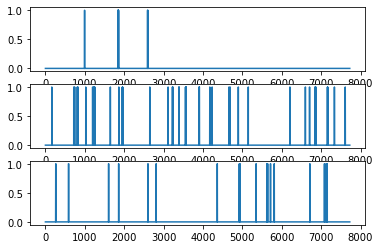

In [568]:
# remove no behav recording period
behav_mask = (ms_time>=behav_time[0]) & (ms_time<behav_time[-1])
FiltTraces_behav = FiltTraces[:,behav_mask]
RawTraces_behav = RawTraces[:,behav_mask]
DeconvSignal_behav = DeconvSignal[:,behav_mask]
ms_time_behav = ms_time[behav_mask]

# plot spike data
deconv_sd = np.std(DeconvSignal_behav, axis = 1) * 3
Spikes = np.where(DeconvSignal_behav>np.repeat(deconv_sd[:,np.newaxis], DeconvSignal_behav.shape[1],1), 1, 0)
plt.subplot(311)
plt.plot(Spikes[1,:])
plt.subplot(312)
plt.plot(Spikes[2,:])
plt.subplot(313)
plt.plot(Spikes[3,:])

In [569]:
n_neuron = Spikes.shape[0]
spike_times = []
for i in range(n_neuron):
    spike_time = ms_time_behav[np.where(Spikes[i,:] == 1)]
    spike_times.append(spike_time)
spike_times = np.array(spike_times, dtype = object)

t_start = max(ms_time[0], behav_time[0])
t_end = max(ms_time[-1], behav_time[-1])
downsample_factor = 10
dt = 100 # ms



In [570]:
neural_data=bin_spikes(spike_times,dt,t_start,t_end)

#Bin output (velocity) data using "bin_output" function
pos_binned=bin_output(behav_pos_smooth,behav_time,dt,t_start,t_end,downsample_factor) 
# pos_binned=bin_output(np.expand_dims(behav_nodes_interpolated,1),behav_time_original,dt,t_start,t_end,downsample_factor) 

D:\Softwares\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Softwares\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [584]:
bins_before=7 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=4 #How many bins of neural data after the output are used for decoding

In [585]:
#Remove neurons with too few spikes in HC dataset
nd_sum=np.nansum(neural_data,axis=0) #Total number of spikes of each neuron
rmv_nrn=np.where(nd_sum<20) #Find neurons who have less than 100 spikes total
neural_data=np.delete(neural_data,rmv_nrn,1) #Remove those neurons
X=neural_data

In [586]:
#Set decoding output
y=pos_binned

In [587]:
#Number of bins to sum spikes over
N=bins_before+bins_current+bins_after 

In [588]:
#Remove time bins with no output (y value)
rmv_time=np.where(np.isnan(y[:,0]) | np.isnan(y[:,1]))
X=np.delete(X,rmv_time,0)
y=np.delete(y,rmv_time,0)

In [589]:
#Set what part of data should be part of the training/testing/validation sets

training_range=[0, 0.8]
valid_range=[0.8,0.9]
testing_range=[0.9, 1]

#Number of examples after taking into account bins removed for lag alignment
num_examples=X.shape[0]

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples))+bins_before,np.int(np.round(testing_range[1]*num_examples))-bins_after)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples))+bins_before,np.int(np.round(valid_range[1]*num_examples))-bins_after)

#Get training data
X_train=X[training_set,:]
y_train=y[training_set,:]

#Get testing data
X_test=X[testing_set,:]
y_test=y[testing_set,:]

#Get validation data
X_valid=X[valid_set,:]
y_valid=y[valid_set,:]

<ipython-input-589-66c7609f5761>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
<ipython-input-589-66c7609f5761>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish t

In [590]:
#Initialize matrices for neural data in Naive bayes format
num_nrns=X_train.shape[1]
X_b_train=np.empty([X_train.shape[0]-N+1,num_nrns])
X_b_valid=np.empty([X_valid.shape[0]-N+1,num_nrns])
X_b_test=np.empty([X_test.shape[0]-N+1,num_nrns])

#Below assumes that bins_current=1 (otherwise alignment will be off by 1 between the spikes and outputs)

#For all neurons, within all the bins being used, get the total number of spikes (sum across all those bins)
#Do this for the training/validation/testing sets
for i in range(num_nrns):
    X_b_train[:,i]=N*np.convolve(X_train[:,i], np.ones((N,))/N, mode='valid') #Convolving w/ ones is a sum across those N bins
    X_b_valid[:,i]=N*np.convolve(X_valid[:,i], np.ones((N,))/N, mode='valid')
    X_b_test[:,i]=N*np.convolve(X_test[:,i], np.ones((N,))/N, mode='valid')

#Make integer format
X_b_train=X_b_train.astype(int)
X_b_valid=X_b_valid.astype(int)
X_b_test=X_b_test.astype(int)

#Make y's aligned w/ X's
#e.g. we have to remove the first y if we are using 1 bin before, and have to remove the last y if we are using 1 bin after
if bins_before>0 and bins_after>0:
    y_train=y_train[bins_before:-bins_after,:]
    y_valid=y_valid[bins_before:-bins_after,:]
    y_test=y_test[bins_before:-bins_after,:]
    
if bins_before>0 and bins_after==0:
    y_train=y_train[bins_before:,:]
    y_valid=y_valid[bins_before:,:]
    y_test=y_test[bins_before:,:]

In [591]:
#Declare model

#The parameter "encoding_model" can either be linear or quadratic, although additional encoding models could later be added.

#The parameter "res" is the number of bins used (resolution) for decoding predictions
#So if res=100, we create a 100 x 100 grid going from the minimum to maximum of the output variables (x and y positions)
#The prediction the decoder makes will be a value on that grid 

model_nb=NaiveBayesDecoder(encoding_model='quadratic',res=12)

#Fit model
model_nb.fit(X_b_train,y_train)

In [592]:
#Get predictions
#y_valid_predicted=model_nb.predict(X_b_valid,y_valid)
y_train_predicted=model_nb.predict(X_b_train,y_train)

In [593]:
#Get metric of fit
R2_nb=get_R2(y_train,y_train_predicted)
print(R2_nb)

[0.65717755 0.75986323]


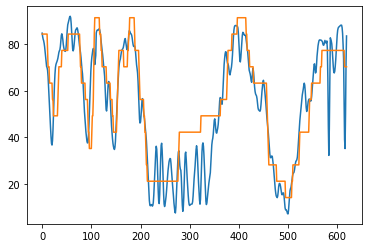

In [594]:
#Make example plot
plt.plot(y_train[:,1])
plt.plot(y_train_predicted[:,1])

In [595]:
#Get predictions
np.median(np.abs(y_train - y_train_predicted))

6.950965140065193